In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import math

In [2]:
import numpy
from urllib.request import urlopen
import scipy.optimize
import random
from math import exp
from math import log

def parseData(fname):
  for l in urlopen(fname):
    yield eval(l)

print("Reading data...")
data = list(parseData("http://jmcauley.ucsd.edu/cse190/data/beer/beer_50000.json"))
print("done")

def feature(datum):
  feat = [1, datum['review/taste'], datum['review/appearance'], datum['review/aroma'], datum['review/palate'], datum['review/overall']]
  return feat

X = [feature(d) for d in data]
y = [d['beer/ABV'] >= 6.5 for d in data]

def inner(x,y):
  return sum([x[i]*y[i] for i in range(len(x))])

def sigmoid(x):
  return 1.0 / (1 + exp(-x))

##################################################
# Logistic regression by gradient ascent         #
##################################################

# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
  loglikelihood = 0
  for i in range(len(X)):
    logit = inner(X[i], theta)
    loglikelihood -= log(1 + exp(-logit))
    if not y[i]:
      loglikelihood -= logit
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print("ll =" + str(loglikelihood))
  return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      dl[k] += X[i][k] * (1 - sigmoid(logit))
      if not y[i]:
        dl[k] -= X[i][k]
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return numpy.array([-x for x in dl])

X_train = X
y_train = y

##################################################
# Train                                          #
##################################################

def train(lam):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, args = (X_train, y_train, lam))
  return theta

##################################################
# Predict                                        #
##################################################

def performance(theta):
    scores = [inner(theta,x) for x in X]
    predictions = [s > 0 for s in scores]
    correct = [(a==b) for (a,b) in zip(predictions,y_train)]
    acc = sum(correct) * 1.0 / len(correct)
    return acc

##################################################
# Validation pipeline                            #
##################################################

lam = 1.0

theta = train(lam)
acc = performance(theta)
print("lambda = " + str(lam) + ":\taccuracy=" + str(acc))

Reading data...
done
lambda = 1.0:	accuracy=0.71868


In [3]:
#Question 1
dataCopy = data.copy()
random.shuffle(dataCopy)
data_train = dataCopy[:len(dataCopy)//3]
data_test = dataCopy[len(dataCopy)//3:round(2*len(dataCopy)/3)]
data_valid = dataCopy[round(2*len(dataCopy)/3):]

print('Length of sets: Train {}, Test {}, Validate {}'.format(len(data_train), len(data_test), len(data_valid)))

X_train = [feature(d) for d in data_train]
y_train = [d['beer/ABV'] >= 6.5 for d in data_train]
X_test = [feature(d) for d in data_test]
y_test = [d['beer/ABV'] >= 6.5 for d in data_test]
X_valid = [feature(d) for d in data_valid]
y_valid = [d['beer/ABV'] >= 6.5 for d in data_valid]

def performance(theta, featureM, labelM):
    scores = [inner(theta,x) for x in featureM]
    predictions = [s > 0 for s in scores]
    correct = [(a==b) for (a,b) in zip(predictions,labelM)]
    acc = sum(correct) * 1.0 / len(correct)
    return acc

theta = train(lam)
print('Training performance: {}'.format(performance(theta, X_train, y_train)))
print('Test set performance: {}'.format(performance(theta, X_test, y_test)))
print('Validation set performance: {}'.format(performance(theta, X_valid, y_valid)))

Length of sets: Train 16666, Test 16667, Validate 16667
Training performance: 0.7207488299531981
Test set performance: 0.7188456230875383
Validation set performance: 0.7177656446871062


In [4]:
#Question 2
def performance(theta, featureM, labelM, mode='P'):
    scores = [inner(theta,x) for x in featureM]
    predictions = [s > 0 for s in scores]
    if (mode == 'TP'):
        correct = sum([(a==b and a == 1) for (a,b) in zip(predictions,labelM)])
    if (mode == 'TN'):
        correct = sum([(a==b and a == 0) for (a,b) in zip(predictions,labelM)])
    if (mode == 'P'):
        correct = sum([(a == 1) for (a,b) in zip(predictions,labelM)])
    if (mode == 'N'):
        correct = sum([(a == 0) for (a,b) in zip(predictions,labelM)])
    if (mode == 'FP'):
        correct = sum([(a!=b and a == 1) for (a,b) in zip(predictions,labelM)])
    if (mode == 'FN'):
        correct = sum([(a!=b and a == 0) for (a,b) in zip(predictions,labelM)])
    return correct
TP = performance(theta, X_test, y_test, 'TP')
TN = performance(theta, X_test, y_test, 'TN')
P = performance(theta, X_test, y_test, 'P')
N = performance(theta, X_test, y_test, 'N')
FP = performance(theta, X_test, y_test, 'FP')
FN = performance(theta, X_test, y_test, 'FN')
print('True Positives: {}'.format(TP))
print('True Negatives: {}'.format(TN))
print('Positives: {}'.format(P))
print('Negatives: {}'.format(N))
print('False Positives: {}'.format(FP))
print('False Negatives: {}'.format(FN))


True Positives: 8990
True Negatives: 2991
Positives: 12314
Negatives: 4353
False Positives: 3324
False Negatives: 1362


In [5]:
#Question 3
print('Precision: {}'.format(TP/(TP+FP)))
print('Recall: {}'.format(TP/(TP+FN)))

def PRL(theta, featureM, labelM, limit):
    scores = [inner(theta,x) for x in featureM]
    sortedScores = sorted(zip(scores, labelM), key=lambda tup:tup[0],reverse=True)
    sortedLabels = [i[1] for i in sortedScores]
    sortedPreds = [i[0] > 0 for i in sortedScores]
    TP = sum([(a==b and a == 1) for (a,b) in zip(sortedPreds[:limit],sortedLabels[:limit])])
    FP = correct = sum([(a!=b and a == 1) for (a,b) in zip(sortedPreds[:limit],sortedLabels[:limit])])
    FN = correct = sum([(a!=b and a == 0) for (a,b) in zip(sortedPreds[:limit],sortedLabels[:limit])])
    if (TP != 0):
        return (TP/(TP+FP), TP/(TP+FN))
    else:
        return(0,0)
results = PRL(theta, X_test, y_test, 100)
print('Precision@100: {}'.format(results[0]))
print('Recall@100: {}'.format(results[1]))

Precision: 0.7300633425369498
Recall: 0.8684312210200927
Precision@100: 0.95
Recall@100: 1.0


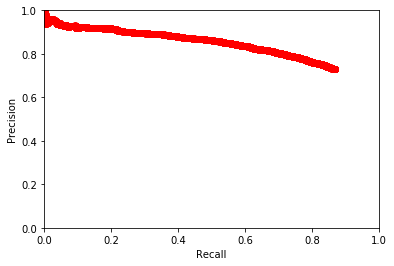

In [6]:
#Question 4
def PRL(theta, featureM, labelM):
    scores = [inner(theta,x) for x in featureM]
    sortedScores = sorted(zip(scores, labelM), key=lambda tup:tup[0],reverse=True)
    sortedLabels = [i[1] for i in sortedScores]
    sortedPreds = [i[0] > 0 for i in sortedScores]
    return (sortedPreds, sortedLabels)

(preds, labels) = PRL(theta, X_test, y_test)
resultP = []
resultR = []
TP_all = [(a==b and a == 1) for (a,b) in zip(preds,labels)]
FP_all = [(a!=b and a == 1) for (a,b) in zip(preds,labels)]
FN_all = [(a!=b and a == 0) for (a,b) in zip(preds,labels)]
TP = 0
TP_sum = sum(TP_all)
FP = 0
FN = sum(FN_all)
for limit in range(len(X_test)):
    TP += TP_all[limit]
    FP += FP_all[limit]
#    FN += FN_all[limit]
    if (TP != 0):
        resultP.append(TP/(TP+FP))
        resultR.append(TP/(TP_sum+FN))
    else:
        resultP.append(0)
        resultR.append(0)
plt.plot(resultR, resultP, 'ro')
plt.axis([0, 1, 0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [7]:
#Question 5
inputF = open('egonet.txt', 'r')
G = nx.Graph()
nodes = []
edges = []
for line in inputF.readlines():
    both = line.split(' ')
    first = both[0]
    second = both[1].split('\n')[0]
    nodes.append(first)
    nodes.append(second)
    edges.append((first,second))
uniqueNodes = set(nodes)
for node in uniqueNodes:
    G.add_node(node)
for edge in edges:
    G.add_edge(*edge)
CCs = list(nx.connected_components(G))

maxVal = 0
for CC in CCs:
    if len(CC) > maxVal:
        maxVal = len(CC)
        maxCC = CC
print('Size of the biggest connected component: {}'.format(maxVal))
print('Connected component:{}'.format(maxCC))


Size of the biggest connected component: 40
Connected component:{'878', '888', '886', '830', '708', '805', '774', '713', '840', '810', '747', '856', '869', '876', '772', '890', '719', '882', '804', '769', '745', '880', '753', '823', '863', '703', '800', '828', '893', '884', '889', '803', '729', '825', '819', '811', '798', '861', '697', '864'}


In [8]:
#Question 6
sortedCC = sorted(maxCC)
minVals = sortedCC[:round(len(maxCC)/2)]
maxVals = sortedCC[round(len(maxCC)/2):]
print('Normalized cut cost: {}'.format(nx.normalized_cut_size(G,minVals,maxVals)))
print('First part: {}'.format(minVals))
print('Second part: {}'.format(maxVals))

Normalized cut cost: 0.8448117539026632
First part: ['697', '703', '708', '713', '719', '729', '745', '747', '753', '769', '772', '774', '798', '800', '803', '804', '805', '810', '811', '819']
Second part: ['823', '825', '828', '830', '840', '856', '861', '863', '864', '869', '876', '878', '880', '882', '884', '886', '888', '889', '890', '893']


In [9]:
#Question 7
minCost = 1.1
currentCost = 1.0
stable1 = minVals.copy()
stable2 = maxVals.copy()
while (currentCost < minCost):
    minCost = currentCost
    minValIter = 1.0
    minId = ''
    for i in range(len(stable1)):
        val = stable1[i]
        testCut1 = stable1.copy()
        testCut1.remove(val)
        testCut2 = stable2.copy()
        testCut2.append(val)
        cost = nx.normalized_cut_size(G,testCut1,testCut2)
        if (cost < minValIter):
            minId = val
            minValIter = cost
        if (cost == minValIter and int(minId) > int(val) if minId != '' else True):
            minId = val
            minValIter = cost
            
    for i in range(len(stable2)):
        val = stable2[i]
        testCut1 = stable1.copy()
        testCut1.append(val)
        testCut2 = stable2.copy()
        testCut2.remove(val)
        cost = nx.normalized_cut_size(G,testCut1,testCut2)
        if (cost < minValIter):
            minId = val
            minValIter = cost
        if (cost == minValIter and int(minId) > int(val) if minId != '' else True):
            minId = val
            minValIter = cost
    if minValIter < currentCost:
        if (minId in stable1):
            stable1.remove(minId)
            stable2.append(minId)
        else:
            stable1.append(minId)
            stable2.remove(minId)
        currentCost = minValIter
print('First split elements: {}'.format(stable1))
print('Second split elements: {}'.format(stable2))
print('Minimum normalized cut cost this split achieves: {}'.format(nx.normalized_cut_size(G,stable1,stable2)))

First split elements: ['697', '703', '708', '713', '719', '745', '747', '753', '769', '772', '774', '798', '800', '803', '805', '810', '811', '819', '828', '823', '830', '840', '880', '890', '869', '856']
Second split elements: ['825', '861', '863', '864', '876', '878', '882', '884', '886', '888', '889', '893', '729', '804']
Minimum normalized cut cost this split achieves: 0.19634091923248548


In [10]:
#Question 8
def modularity(G, communities, weight=None):
    def calculateE(c):
        edgesOf = list(combinations(c,2))
        num_edges = 0
        for combo in edgesOf:
            num_edges += G.number_of_edges(*combo)
        return num_edges/G.number_of_edges()
    def calculateA(c):
        for node in c:
            endpoints = G[node]
            num_endpoints = len(endpoints)
            if (node in endpoints):
                num_endpoints += 1
            return num_endpoints/(G.number_of_edges()*2)
    Q = 0
    for c in communities:
        Q += (calculateE(c) - (calculateA(c)**2))
    return Q
moduleList = [set([i]) for i in sortedCC]
currentScore = modularity(G, moduleList)
maxScore = -math.inf
print('Initial communities: {}'.format(moduleList))
while (currentScore > maxScore):
    maxScore = currentScore
    currentIter = currentScore
    for i in range(len(moduleList)):
        for j in range(i+1,len(moduleList)):
            temp = moduleList.copy()
            join1 = moduleList[i]
            join2 = moduleList[j]
            joined = join1.union(join2)
            temp.remove(join1)
            temp.remove(join2)
            temp.append(joined)
            currentVal = modularity(G,temp)
            if (currentVal > currentIter):
                maxList = temp
                currentIter = currentVal
    if (currentIter > currentScore):
        currentScore = currentIter
        moduleList = temp
print('Communities are enclosed by curly braces')
print('Maximum modularity achieved: {}'.format(currentScore))
print('Maximum modularity communities: {}'.format(moduleList))

Initial communities: [{'697'}, {'703'}, {'708'}, {'713'}, {'719'}, {'729'}, {'745'}, {'747'}, {'753'}, {'769'}, {'772'}, {'774'}, {'798'}, {'800'}, {'803'}, {'804'}, {'805'}, {'810'}, {'811'}, {'819'}, {'823'}, {'825'}, {'828'}, {'830'}, {'840'}, {'856'}, {'861'}, {'863'}, {'864'}, {'869'}, {'876'}, {'878'}, {'880'}, {'882'}, {'884'}, {'886'}, {'888'}, {'889'}, {'890'}, {'893'}]
Communities are enclosed by curly braces
Maximum modularity achieved: 0.814537037037037
Maximum modularity communities: [{'878', '888', '886', '830', '708', '805', '774', '713', '840', '810', '747', '856', '869', '876', '772', '890', '719', '882', '804', '769', '745', '880', '753', '823', '863', '703', '800', '828', '893', '884', '803', '889', '729', '798', '825', '819', '811', '861', '697', '864'}]
